In [7]:
import librosa
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import time
import glob
from lxml.html import parse
from sphfile import SPHFile
import pydub
import audiosegment
import pandas as pd
from collections import Counter
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x):
        return self.func(x)
dropout = 0.3
half = False
sr = 16000

## Pair sound files and annotation

In [2]:
soundfiles = glob.glob('testfiles/**/*.sph', recursive = True)
#annofiles = glob.glob('./**/*.txt', recursive = True) + glob.glob('./**/*.sgml', recursive = True)
data = {}
for soundfile in soundfiles:
    name = soundfile.split('/')[-1].split('.')[0]
    annofile = list(glob.glob('testfiles/**/'+name+'*.utf', recursive = True))
    annofile = annofile[0]
    print(soundfile, annofile)
    data[soundfile] = annofile
start_load = time.time()
sph = SPHFile(soundfiles[0])
junk, sr = sph.content, sph.format['sample_rate']
if sph.format['sample_byte_format'] == '01':
    junk = junk.byteswap()
print(time.time()-start_load)
ipd.Audio(junk[:2*sr], rate = sr)

testfiles/LDC2000S86/h4e_evl/h4e_98_2.sph testfiles/LDC2000S86/transcripts/h4e_98_2-v7.utf
testfiles/LDC2000S86/h4e_evl/h4e_98_1.sph testfiles/LDC2000S86/transcripts/h4e_98_1-v4.utf
testfiles/LDC2000S88/bnews_99/bn99en_2.sph testfiles/LDC2000S88/transcripts/bn99en_2.utf
testfiles/LDC2000S88/bnews_99/bn99en_1.sph testfiles/LDC2000S88/transcripts/bn99en_1.utf
0.7462260723114014


-80.0

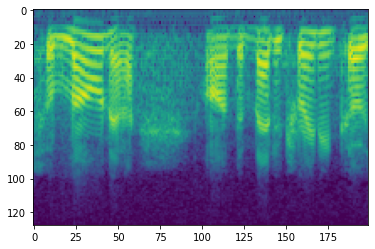

In [3]:
S = librosa.feature.melspectrogram(junk[1000*sr:1002*sr]/(2**15), n_mels = 128, n_fft = 512, hop_length = 161) # 32 ms window, 10 ms hop
S_dB = librosa.power_to_db(S, ref=np.max)
plt.imshow(S_dB)
S_dB.min()

In [4]:
speakers = {}
for annofile in data.values():
    doc = parse(annofile)
    tags = [item for item in doc.getroot().iter() if item.tag == 'turn']
    for tag in tags:
        speaker = tag.attrib['speaker']
        if speaker not in speakers:
            speakers[speaker] = 1
        else:
            speakers[speaker] +=1
speakers

{'Al_Goodman': 4,
 'Alan_Little': 1,
 'Allan_Dodds_Frank': 4,
 'Andrew_Good': 1,
 'Andrew_Harding': 1,
 'Anita_Hill': 1,
 'Ann_Leonard': 1,
 'Ann_Phillips': 2,
 'Antoine_Adrian': 1,
 'Aram_Roston': 6,
 'Barbara_Hall': 5,
 'Barney_Frank': 1,
 'Barry_Toyve': 1,
 'Bernard_Shaw': 3,
 'Bill_Clinton': 5,
 'Bill_Hemmer': 56,
 'Bill_Lockyer': 2,
 'Bill_Owens': 2,
 'Bill_Richardson': 1,
 'Bob_Franken': 2,
 'Bob_Shrum': 1,
 'Boris_Yeltsin': 3,
 'Bradford_Berenson': 1,
 'Brian_Cabell': 6,
 'Brian_Jenkins': 4,
 'Bruce_Burkhardt': 3,
 'Candy_Crowley': 5,
 'Carol_Penno': 1,
 'Carrie_Pollack': 1,
 'Charles_Bierbauer': 9,
 'Charles_Feldman': 4,
 'Charles_Gibson': 6,
 'Charles_Molineaux': 4,
 'Charlie': 9,
 'Christa_Tess': 2,
 'Christiane_Amanpour': 6,
 'Christina_Zorich': 5,
 'Connie_Brod': 46,
 'Constance_Freeman': 6,
 'Corey_Flintoff': 10,
 'Craig_Burkey': 2,
 'Craig_Wintom': 11,
 'Daniel_Patrick_Moynihan': 1,
 'Daniel_Snyder': 8,
 'Daryn_Kagan': 32,
 'Daryn_Kagen': 1,
 'Dave_Hennen': 11,
 'Dave_Lap

## Annotation Example

In [5]:
annofile = data[soundfiles[np.random.randint(len(soundfiles))]]
doc = parse(annofile)
last_end = 0
for tag in doc.getroot().iter():
    if tag.tag == 'segment': # segment for txt files, turn for sgml files
        pass
        #print(tag.attrib, tag.text, tag.tag, '\n')
        if float(tag.attrib['s_time'])<last_end:
            print('interrupt', last_end, tag.attrib['s_time'])
        last_end = float(tag.attrib['e_time'])
    elif tag.tag == 'turn':
        pass
        #print(tag.attrib, tag.text, tag.tag, '\n')
        if float(tag.attrib['starttime'])<last_end:
            print('interrupt', last_end, tag.attrib['starttime'])
        last_end = float(tag.attrib['endtime'])
tags = [item for item in doc.getroot().iter() if item.tag in ['segment', 'turn']]
segment_idx = np.random.randint(0, len(tags))
example_tag = tags[segment_idx]
if example_tag.tag == 'segment':
    start, end = example_tag.attrib['s_time'], example_tag.attrib['e_time']
else:
    start, end = example_tag.attrib['starttime'], example_tag.attrib['endtime']
print(start, end, example_tag.text_content(), example_tag.attrib['speaker'])
end = int(float(end)*sr)
start = max(end-2*sr, int(float(start)*sr))

interrupt 941.79825 939.60438
interrupt 1053.643688 1052.91750
interrupt 1075.26225 1073.673813
interrupt 1165.73231 1165.41919
interrupt 1181.77825 1181.34337
interrupt 1222.24181 1221.901813
interrupt 1265.90556 1265.16362
interrupt 1289.65856 1289.271188
interrupt 1312.1655 1311.47969
interrupt 1313.55144 1312.89912
interrupt 1368.66031 1367.06887
interrupt 1404.57869 1403.85625
interrupt 1412.48488 1411.92419
interrupt 1415.93238 1415.356625
interrupt 1426.111 1424.29706
interrupt 1430.83738 1430.021
interrupt 1480.41806 1480.002751
interrupt 1494.10269 1493.02087
interrupt 1499.243876 1498.62250
interrupt 1500.16869 1499.83012
interrupt 1503.92419 1503.32719
interrupt 1559.58931 1552.607
interrupt 1614.72131 1614.32413
interrupt 1667.58638 1667.22925
interrupt 1992.36275 1991.35531
interrupt 2020.11619 2018.38219
interrupt 2065.32156 2065.07062
interrupt 2099.21919 2098.77694
interrupt 2106.37481 2105.838
interrupt 2109.01356 2108.58319
interrupt 2119.61856 2118.907875
interrupt 2

# Ending Segments

In [6]:
percents = []
# emptiness = []
end_df = pd.DataFrame()
for i, soundfile in enumerate(soundfiles):
    name = soundfile.split('/')[-1].split('.')[0] # name of soundfile
    print(i)
    sph = SPHFile(soundfile)
    sound, sr = sph.content, sph.format['sample_rate']
    if sph.format['sample_byte_format'] == '01':
        sound = sound.byteswap()
    annofile = data[soundfile]
    doc = parse(annofile)
    tags = [item for item in doc.getroot().iter() if item.tag in ['segment', 'turn']]
    for j, segment in enumerate(tags):
        speaker = segment.attrib['speaker']
        if segment.tag == 'segment':
            start, end = segment.attrib['s_time'], segment.attrib['e_time']
            if j + 1 < len(tags) and float(tags[j+1].attrib['s_time']) < float(end): # if someone interrupted talking
                #print('interrupt')
                continue
        else:
            start, end = segment.attrib['starttime'], segment.attrib['endtime']
            if j + 1 < len(tags) and float(tags[j+1].attrib['starttime']) < float(end): # if someone interrupted talking
                #print('interrupt')
                continue
        if float(end) > len(sound)/sr: # if end exceeds length, skip
            continue
        end = int(float(end)*sr) # turn to sample index
        start = int(float(start)*sr) # turn to sample index
        if start >= end - 2*sr: # if segment too short
            continue
        start = end-2*sr
        
        
        sound_segment = sound[start:end]
        seg = audiosegment.from_numpy_array(sound_segment, sr)
        silences = pydub.silence.detect_silence(seg, min_silence_len = 100, silence_thresh=-32, seek_step = 30)
        silences = [[int(a/1000*sr),int(b/1000*sr)] for [a, b] in silences]
        if silences!= []:
            if silences[-1][1] == 2*sr: # if silence at end, remove that silence
                end = end - 2*sr + silences[-1][0] # readjust silence end
                if segment.tag == 'segment':
                    start = int(float(segment.attrib['s_time'])*sr)
                else:
                    start = int(float(segment.attrib['starttime'])*sr)
                if start >= end - 2*sr: # if segment too short
                    continue
                start = end - 2*sr
        
        
        # recrop
        sound_segment = sound[start:end]
        seg = audiosegment.from_numpy_array(sound_segment, sr)
        # recalculate silence
        silences = pydub.silence.detect_silence(seg, min_silence_len = 100, silence_thresh=-32, seek_step = 30)
        silences = [[int(a/1000*sr),int(b/1000*sr)] for [a, b] in silences]
        #if silences!=[]: # print out start of first silence, if any
        #    print(silences[0][0])
        length_silence = sum([b-a for [a, b] in silences])
        percents.append(length_silence/len(sound_segment))
        if length_silence/len(sound_segment) <= 0.3:
            filename = 'testfiles/end_segments/'+name+'seg'+str(j)+'.npy'
            np.save(filename, sound_segment)
            row = {'file': soundfile, 'segment': j, 'start': start, 'end': end, 
                   'silence_ratio': length_silence/len(sound_segment), 'speaker':speaker, 'filename':filename}
            end_df = end_df.append(row, ignore_index = True)
        
        #for [a, b] in silences:
        #    emptiness += list(sound_segment[a:b])

0
1
2
3


In [7]:
end_df.to_csv('testfiles/end.csv', index = False)
end_df

,end,file,filename,segment,silence_ratio,speaker,start
0,480442.0,testfiles/LDC2000S86/h4e_evl/h4e_98_2.sph,testfiles/end_segments/h4e_98_2seg1.npy,1.0,0.180,Lisa_Stark,448442.0
1,615498.0,testfiles/LDC2000S86/h4e_evl/h4e_98_2.sph,testfiles/end_segments/h4e_98_2seg2.npy,2.0,0.000,spkr_6,583498.0
2,763770.0,testfiles/LDC2000S86/h4e_evl/h4e_98_2.sph,testfiles/end_segments/h4e_98_2seg3.npy,3.0,0.185,Lisa_Stark,731770.0
3,868426.0,testfiles/LDC2000S86/h4e_evl/h4e_98_2.sph,testfiles/end_segments/h4e_98_2seg4.npy,4.0,0.000,Christa_Tess,836426.0
4,1176314.0,testfiles/LDC2000S86/h4e_evl/h4e_98_2.sph,testfiles/end_segments/h4e_98_2seg5.npy,5.0,0.065,Lisa_Stark,1144314.0
...,...,...,...,...,...,...,...
765,56581280.0,testfiles/LDC2000S88/bnews_99/bn99en_1.sph,testfiles/end_segments/bn99en_1seg222.npy,222.0,0.080,Jeanne_Moos,56549280.0
766,56698336.0,testfiles/LDC2000S88/bnews_99/bn99en_1.sph,testfiles/end_segments/bn99en_1seg223.npy,223.0,0.000,Laura_Robbins,56666336.0
767,85906560.0,testfiles/LDC2000S88/bnews_99/bn99en_1.sph,testfiles/end_segments/bn99en_1seg230.npy,230.0,0.080,spkr_2,85874560.0
768,87671056.0,testfiles/LDC2000S88/bnews_99/bn99en_1.sph,testfiles/end_segments/bn99en_1seg235.npy,235.0,0.000,spkr_2,87639056.0


## Starting segments

In [8]:
percents = []
#emptiness = []
start_df = pd.DataFrame() # different
for i, soundfile in enumerate(soundfiles):
    name = soundfile.split('/')[-1].split('.')[0] # name of soundfile
    print(i)
    sph = SPHFile(soundfile)
    sound, sr = sph.content, sph.format['sample_rate']
    if sph.format['sample_byte_format'] == '01':
        sound = sound.byteswap()
    annofile = data[soundfile]
    doc = parse(annofile)
    tags = [item for item in doc.getroot().iter() if item.tag in ['segment', 'turn']]
    for j, segment in enumerate(tags):
        speaker = segment.attrib['speaker']
        if segment.tag == 'segment':
            start, end = segment.attrib['s_time'], segment.attrib['e_time']
            if j > 0 and float(tags[j-1].attrib['e_time']) > float(start): #if someone interrupted talking
                #print('interrupt')
                continue
        else:
            start, end = segment.attrib['starttime'], segment.attrib['endtime']
            if j > 0 and float(tags[j-1].attrib['endtime']) > float(start): #if someone interrupted talking
                #print('interrupt')
                continue
        if float(end) > len(sound)/sr: # if end exceeds length, skip
            continue
        end = int(float(end)*sr) # turn to sample index
        start = int(float(start)*sr) # turn to sample index
        if start >= end - 2*sr: # if segment too short
            continue
        end = start + 2*sr   # different
        

        sound_segment = sound[start:end]
        seg = audiosegment.from_numpy_array(sound_segment, sr)
        silences = pydub.silence.detect_silence(seg, min_silence_len = 100, silence_thresh=-32, seek_step = 30)
        silences = [[int(a/1000*sr),int(b/1000*sr)] for [a, b] in silences]
        if silences!= []:
            if silences[0][0] == 0: # if silence at start, remove that silence # different
                start = start + silences[0][1] - int(0.1*sr) # readjust silence start # different, include attack
                if segment.tag == 'segment':
                    end = int(float(segment.attrib['e_time'])*sr) # different
                else:
                    end = int(float(segment.attrib['endtime'])*sr) # different
                if start >= end - 2*sr: # if segment too short
                    continue
                end = start + 2*sr # different
        # recrop
        sound_segment = sound[start:end]
        seg = audiosegment.from_numpy_array(sound_segment, sr)
        # recalculate silence
        silences = pydub.silence.detect_silence(seg, min_silence_len = 100, silence_thresh=-32, seek_step = 30)
        silences = [[int(a/1000*sr),int(b/1000*sr)] for [a, b] in silences]
        #if silences!=[]: # print out end of first silence, if any
        #    print(silences[0][1]) # different
        length_silence = sum([b-a for [a, b] in silences])
        percents.append(length_silence/len(sound_segment))
        if length_silence/len(sound_segment) <= 0.3:
            filename = 'testfiles/start_segments/'+name+'seg'+str(j)+'.npy'
            np.save(filename, sound_segment)
            row = {'file': soundfile, 'segment': j, 'start': start, 'end': end, 
                   'silence_ratio': length_silence/len(sound_segment), 'speaker':speaker, 'filename':filename}
            start_df = start_df.append(row, ignore_index = True) # different
        
        #for [a, b] in silences:
        #    emptiness += list(sound_segment[a:b])

0
1
2
3


In [9]:
start_df.to_csv('testfiles/start.csv', index = False)
start_df

,end,file,filename,segment,silence_ratio,speaker,start
0,46906.0,testfiles/LDC2000S86/h4e_evl/h4e_98_2.sph,testfiles/start_segments/h4e_98_2seg0.npy,0.0,0.100,Peter_Jennings,14906.0
1,458400.0,testfiles/LDC2000S86/h4e_evl/h4e_98_2.sph,testfiles/start_segments/h4e_98_2seg1.npy,1.0,0.155,Lisa_Stark,426400.0
2,516602.0,testfiles/LDC2000S86/h4e_evl/h4e_98_2.sph,testfiles/start_segments/h4e_98_2seg2.npy,2.0,0.115,spkr_6,484602.0
3,653098.0,testfiles/LDC2000S86/h4e_evl/h4e_98_2.sph,testfiles/start_segments/h4e_98_2seg3.npy,3.0,0.280,Lisa_Stark,621098.0
4,799930.0,testfiles/LDC2000S86/h4e_evl/h4e_98_2.sph,testfiles/start_segments/h4e_98_2seg4.npy,4.0,0.115,Christa_Tess,767930.0
...,...,...,...,...,...,...,...
886,56402240.0,testfiles/LDC2000S88/bnews_99/bn99en_1.sph,testfiles/start_segments/bn99en_1seg218.npy,218.0,0.050,Jeanne_Moos,56370240.0
887,56497168.0,testfiles/LDC2000S88/bnews_99/bn99en_1.sph,testfiles/start_segments/bn99en_1seg221.npy,221.0,0.000,spkr_20,56465168.0
888,56549024.0,testfiles/LDC2000S88/bnews_99/bn99en_1.sph,testfiles/start_segments/bn99en_1seg222.npy,222.0,0.180,Jeanne_Moos,56517024.0
889,56616960.0,testfiles/LDC2000S88/bnews_99/bn99en_1.sph,testfiles/start_segments/bn99en_1seg223.npy,223.0,0.200,Laura_Robbins,56584960.0


In [10]:
row = start_df.iloc[np.random.randint(len(start_df))]
row['filename']
print(row)
seg = np.fromfile(row['filename'], dtype = np.int16)
ipd.Audio(seg, rate = sr)

end                                              7.99188e+07
file               testfiles/LDC2000S86/h4e_evl/h4e_98_2.sph
filename         testfiles/start_segments/h4e_98_2seg292.npy
segment                                                  292
silence_ratio                                          0.115
speaker                                            Joie_Chen
start                                            7.98868e+07
Name: 213, dtype: object


## Pool start/end segments

In [4]:
start_df = pd.read_csv('testfiles/start.csv')
end_df = pd.read_csv('testfiles/end.csv')
segments_df = start_df.append(end_df, ignore_index = True)
speaker_count = Counter(list(segments_df['speaker']))

speakers = [x for x in speaker_count if speaker_count[x] >= 10] # for each speaker, we generate a 54*54 pairs and remove those with >1s overlap
speakers = [x for x in speakers if x not in ['ABC_NLI_Announcer', 'CSP_WAJ_Susan', 'Susan', 
                                             'i960604_F_US_001', 'i960604_F_US_026', 'i960711p_anchor2',
                                             'b960530_F_US_007', 'b960530_M_US_008', 'i960604_M_US_027',
                                             'i960711p_johndoe003', 'unknown_car']]
speakers = [x for x in speakers if x[0:4] not in ['male', 'spkr', 'fema', 'repo']]
speakers.sort()
print(len(speakers))

# for faster fetching of pairs negative speaker
start_segments_by_speaker = {}
for speaker in speakers:
    start_segments_by_speaker[speaker] = start_df[start_df['speaker'] == speaker]
for speaker in speakers:
    print(speaker)
segments_df
print

39
Aram_Roston
Bill_Hemmer
Brian_Cabell
Charles_Bierbauer
Christiane_Amanpour
Christina_Zorich
Connie_Brod
Constance_Freeman
Corey_Flintoff
Craig_Wintom
Daniel_Snyder
Daryn_Kagan
Dave_Hennen
David_Brancaccio
Diane_Sawyer
Donna_Kelley
Ed_Garsten
Eddie_Mair
Fred_Francis
Greg_LaMotte
Jeanne_Moos
Jim_Moret
Jocelyn_Ford
John_Palmer
Joie_Chen
Laura_Robbins
Lee_Ann_Elliott
Leon_Harris
Lisa_Mullins
Lyn_Vaughn
Martin_Wells
Miles_OBrien
Paul_Miller
Peter_Jennings
Rhonda_Schaffler
Robert_Nicholson
Sam_Donaldson
Susan_Candiotti
Tony_Kahn


<function print>

In [5]:
def calculate_overlap(row1, row2):
    if row1['file'] != row2['file']: # can only overlap if in same file
        return 0
    if row1['end']<row2['start'] or row1['start']>row2['end']:
        return 0
    if row1['start']<row2['start']:
        return row1['end']-row2['start']
    return row2['end']-row1['start']

## Make pairs

In [9]:
pairs = []
for _, anchor_speaker in enumerate(speakers):
    print(_)
    negative_speakers = [speaker for speaker in speakers if speaker != anchor_speaker]
    anchor_segments = end_df[end_df['speaker'] == anchor_speaker] # at end of segment
    positive_segments = start_df[start_df['speaker'] == anchor_speaker] # at start of segment
    anchor_indices = np.arange(len(anchor_segments))
    np.random.shuffle(anchor_indices)# shuffle the anchor segments
    for i in range(min(len(anchor_segments), 10)):
        anchor_segment = anchor_segments.iloc[anchor_indices[i]]
        positive_indices = np.arange(len(positive_segments))
        np.random.shuffle(positive_indices)# shuffle the anchor segments
        for j in range(min(len(positive_segments), 10)):
            # positive examples
            positive_segment = positive_segments.iloc[positive_indices[j]]
            if calculate_overlap(anchor_segment, positive_segment)>sr: # if overlap greater than 1s
                continue
            # swap 1st 2nd randomly
            pos_row = {'first_speaker': anchor_speaker, 'first_file': anchor_segment['filename'], 
                       'second_speaker': anchor_speaker, 'second_file': positive_segment['filename'],
                       'label': 0} # no speaker change
      
            # negative examples
            negative_speaker = negative_speakers[np.random.randint(0, len(negative_speakers))]
            negative_segments = start_segments_by_speaker[negative_speaker] # segments for a specific random speaker
            negative_segment = negative_segments.iloc[np.random.randint(0, len(negative_segments))]
            neg_row = {'first_speaker': anchor_speaker, 'first_file': anchor_segment['filename'], 
               'second_speaker': negative_speaker, 'second_file': negative_segment['filename'],
               'label': 1} # has speaker change
            pairs.append(pos_row)
            pairs.append(neg_row)
pairs = pd.DataFrame(pairs)
pairs.to_csv('testfiles/pairs.csv')
pairs

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38


,first_speaker,first_file,second_speaker,second_file,label
0,Aram_Roston,testfiles/end_segments/h4e_98_2seg277.npy,Aram_Roston,testfiles/start_segments/h4e_98_2seg281.npy,0
1,Aram_Roston,testfiles/end_segments/h4e_98_2seg277.npy,David_Brancaccio,testfiles/start_segments/h4e_98_1seg23.npy,1
2,Aram_Roston,testfiles/end_segments/h4e_98_2seg277.npy,Aram_Roston,testfiles/start_segments/h4e_98_2seg275.npy,0
3,Aram_Roston,testfiles/end_segments/h4e_98_2seg277.npy,Jocelyn_Ford,testfiles/start_segments/h4e_98_1seg13.npy,1
4,Aram_Roston,testfiles/end_segments/h4e_98_2seg277.npy,Aram_Roston,testfiles/start_segments/h4e_98_2seg283.npy,0
...,...,...,...,...,...
4769,Tony_Kahn,testfiles/end_segments/bn99en_2seg82.npy,Peter_Jennings,testfiles/start_segments/h4e_98_2seg14.npy,1
4770,Tony_Kahn,testfiles/end_segments/bn99en_2seg82.npy,Tony_Kahn,testfiles/start_segments/h4e_98_1seg371.npy,0
4771,Tony_Kahn,testfiles/end_segments/bn99en_2seg82.npy,Jeanne_Moos,testfiles/start_segments/bn99en_1seg208.npy,1
4772,Tony_Kahn,testfiles/end_segments/bn99en_2seg82.npy,Tony_Kahn,testfiles/start_segments/h4e_98_1seg363.npy,0


(128, 399)
different


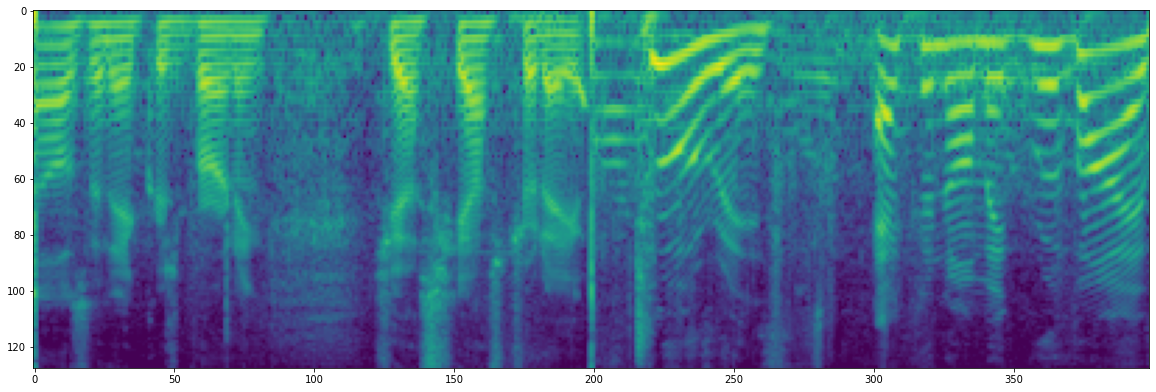

In [10]:
pairs = pd.read_csv('testfiles/pairs.csv')
idx = np.random.randint(0, len(pairs))
pair = pairs.iloc[idx]
first_segment = np.fromfile(pair['first_file'], dtype = np.int16)/(2**15)
second_segment = np.fromfile(pair['second_file'], dtype = np.int16)/(2**15)
S = librosa.feature.melspectrogram(np.concatenate((first_segment, second_segment)), n_mels = 128, n_fft = 512, hop_length = 161) # 32 ms window, 10 ms hop
S_dB = librosa.power_to_db(S, ref=np.max)
print(S_dB.shape)
plt.figure(figsize = (20, 30))
plt.imshow(S_dB)
if pair['label']:
    print('different')
else:
    print('same')
ipd.Audio(np.concatenate((first_segment, second_segment)), rate = sr)
